### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 13 июня 2022, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 13 июня, -4 балла после 08:30 20 июня, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0422, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

$1)\frac{dL(a(x_i), y_i)}{da(x_i)}=-2(y_i-a(x_i))$

$target: 2(y_i-a(x_i))$

$2)\frac{dL(a(x_i), y_i)}{da(x_i)}=-y_i*exp( -a(x_i) y_i)$

$target: y_i*exp( -a(x_i) y_i)$

$3)\frac{dL(a(x_i), y_i)}{da(x_i)}=\frac{-y_i*exp( -a(x_i) y_i)}{(1 + exp( -a(x_i) y_i))}$

$target: \frac{y_i}{(exp(a(x_i) y_i) + 1)}$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [291]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='mse', learning_rate=0.1, n_estimators=100, colsample=1, subsample=1, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        self.loss=loss
        self.learning_rate=learning_rate
        self.n_estimators=n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args=args
        self.kwargs=kwargs
        
    def met_ch(self, X, y, feat, obj):
        #print("in met len(y)", len(y))
        if self.loss == 'mse':
            return (2*(y[obj] - self.predict(X[obj])))
        if self.loss == 'exp':
            return (y[obj]*np.exp(-self.predict(X[obj])*y[obj]))
        if self.loss == 'log':
            return (y[obj]/(np.exp(self.predict(X[obj])*y[obj])+1))
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        # Ваш код здесь
        self.models = []
        obj_size = int(X.shape[0] * self.subsample)
        feat_size = int(X.shape[1] * self.colsample)
        f0 = None 
        if (init_model is not None):
            mod = init_model(*self.args, **self.kwargs)
            f0 = mod.fit(X, y)
        self.models.append(f0)
        for i in range(1, self.n_estimators):
            model = base_model(*self.args, **self.kwargs)
            feat = np.random.permutation(feat_size)
            obj = np.random.permutation(obj_size)
            #print("len obj ", len (obj), " len feat",len(feat))
            #print("len(y)", len(y))
            pred = self.met_ch(X, y, feat, obj)
           # print("obj", obj)
           # print("feat", feat)
            #print("pred", pred)
            #print("len", len (X[obj][:, feat]))
            model.fit(X[obj][:, feat], pred)
            self.models.append([model, feat])
        
    def predict(self, X):
        # Ваш код здесь
        res = np.zeros(len(X))
        count = 0
        for pair in self.models:
            if count == 0 :
                if (pair is not None):
                    res = pair.predict(X)
            else:
                res += self.learning_rate * pair[0].predict(X[:, pair[1]])
            count += 1
        #print(res)
        a = (np.round(res)).astype(int)
        #print(a)
        return a



In [203]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [204]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [205]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [206]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [207]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [208]:
from tqdm import tqdm

In [248]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                    train_size=0.67,
                                                    random_state=42)

In [249]:
x_axis = []
y_axis = []
for i in tqdm(range(1, 150)):
    x_axis.append(i)
    my_clf = MyGradientBoostingClassifier(n_estimators=i)
    my_clf.fit(X_train, y_train)
    accur = accuracy_score(my_clf.predict(X_valid), y_valid)
    y_axis.append(accur)
    


100%|█████████████████████████████████████████| 149/149 [03:05<00:00,  1.25s/it]


In [250]:
y_axis = np.array(y_axis)
best_n_estimators = y_axis.argmax(axis=0) + 1
print("best_n_estimators", best_n_estimators)

best_n_estimators 78


In [251]:
import matplotlib.pyplot as plt

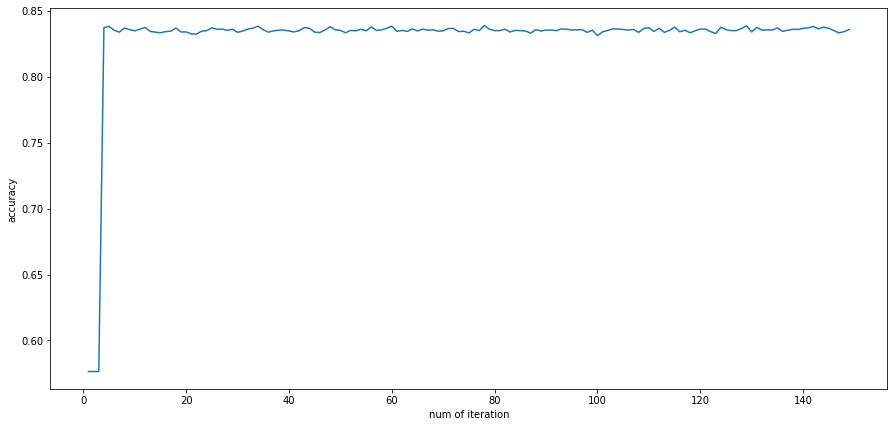

In [252]:
plt.figure(figsize=(15, 7))
plt.plot(x_axis,y_axis)
plt.xlabel("num of iteration")
plt.ylabel("accuracy")
None

In [253]:
d = {}
for loss in tqdm(['mse', 'exp', 'log']):
    my_clf = MyGradientBoostingClassifier(loss=loss, n_estimators=best_n_estimators)
    my_clf.fit(X_train, y_train)
    accur = accuracy_score(my_clf.predict(X_valid), y_valid)
    d[loss] = accur
best_loss = max(d , key=d.get)

100%|█████████████████████████████████████████████| 3/3 [00:19<00:00,  6.45s/it]


In [254]:
print(d)

{'mse': 0.8344098649442161, 'exp': 0.4945684086905461, 'log': 0.5005871990604815}


In [255]:
best_loss

'mse'

In [256]:
lrs = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
accur_lrs = []
for rate in tqdm(lrs):
    my_clf = MyGradientBoostingClassifier(loss=best_loss, n_estimators=best_n_estimators, learning_rate=rate)
    my_clf.fit(X_train, y_train)    
    accur = accuracy_score(my_clf.predict(X_valid), y_valid)
    accur_lrs.append(accur)
    

100%|█████████████████████████████████████████████| 9/9 [00:27<00:00,  3.07s/it]


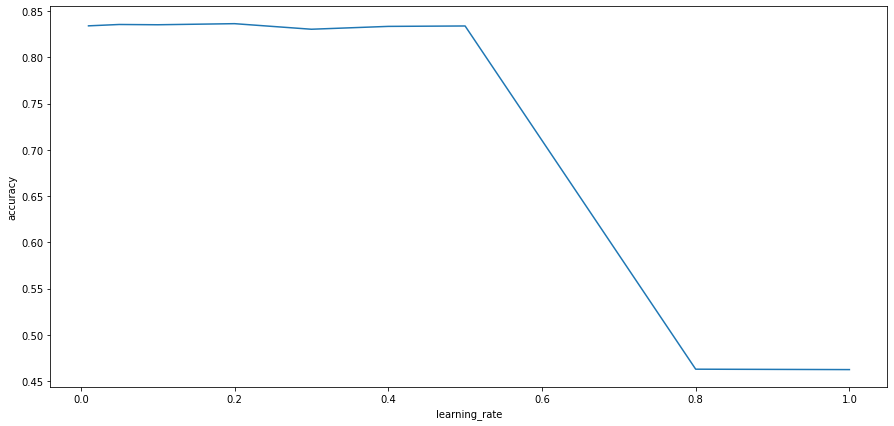

In [261]:
plt.figure(figsize=(15, 7))
plt.plot(lrs, accur_lrs)
plt.xlabel("learning_rate")
plt.ylabel("accuracy")
None

In [265]:
best_learning_rate = lrs[(np.array(accur_lrs)).argmax(axis=0)]
best_learning_rate

0.2

In [260]:
cols = [0.2, 0.4, 0.6, 0.8, 0.85, 0.9, 0.95, 1.0]
accur_cols = []
for col in tqdm(cols):
    my_clf = MyGradientBoostingClassifier(loss=best_loss, n_estimators=best_n_estimators,
                                          learning_rate=best_learning_rate, colsample=col)
    my_clf.fit(X_train, y_train)    
    accur = accuracy_score(my_clf.predict(X_valid), y_valid)
    accur_cols.append(accur)

100%|█████████████████████████████████████████████| 8/8 [00:11<00:00,  1.42s/it]


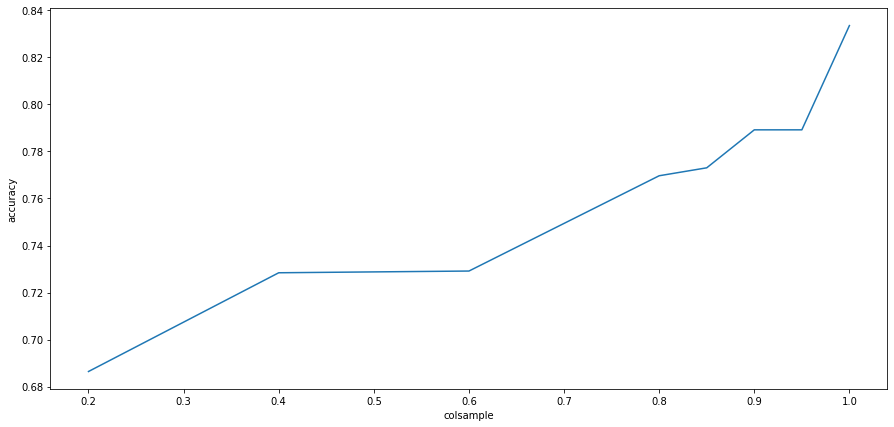

In [263]:
plt.figure(figsize=(15, 7))
plt.plot(cols, accur_cols)
plt.xlabel("colsample")
plt.ylabel("accuracy")
None

In [264]:
best_colsample = cols[(np.array(accur_cols)).argmax(axis=0)]
best_colsample

1.0

In [266]:
subs = [0.2, 0.4, 0.6, 0.8, 0.85, 0.9, 0.95, 1.0]
accur_subs = []
for sub in tqdm(subs):
    my_clf = MyGradientBoostingClassifier(loss=best_loss, n_estimators=best_n_estimators,
                                          learning_rate=best_learning_rate, colsample=best_colsample,
                                          subsample=sub)
    my_clf.fit(X_train, y_train)    
    accur = accuracy_score(my_clf.predict(X_valid), y_valid)
    accur_subs.append(accur)

100%|█████████████████████████████████████████████| 8/8 [00:05<00:00,  1.44it/s]


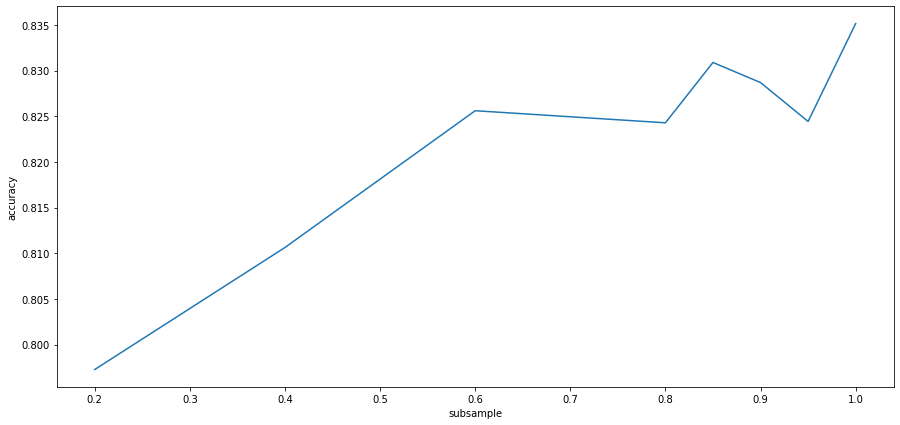

In [267]:
plt.figure(figsize=(15, 7))
plt.plot(subs, accur_subs)
plt.xlabel("subsample")
plt.ylabel("accuracy")
None

In [268]:
best_subsample = subs[(np.array(accur_subs)).argmax(axis=0)]
best_subsample

1.0

In [275]:
print("best_loss:", best_loss)
print("best_n_estimators:", best_n_estimators)
print("best_learning_rate:", best_learning_rate)
print("best_colsample:", best_colsample)
print("best_subsample:", best_subsample)

best_loss: mse
best_n_estimators: 78
best_learning_rate: 0.2
best_colsample: 1.0
best_subsample: 1.0


In [300]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.67,
                                                    random_state=17)
my_clf = MyGradientBoostingClassifier(loss=best_loss, n_estimators=best_n_estimators,
                                          learning_rate=best_learning_rate, colsample=best_colsample,
                                          subsample=best_subsample)
my_clf.fit(X_train, y_train)
accuracy_score(my_clf.predict(X_test), y_test)

0.8371990604815033

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [276]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

In [301]:
my_clf = MyGradientBoostingClassifier(n_estimators=78, learning_rate=0.2, max_depth=10)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.67,
                                                    random_state=42)
my_clf.fit(X_train, y_train, base_model=RandomForestRegressor)
accuracy_score(my_clf.predict(X_test), y_test)

0.8759541984732825

In [302]:
res = np.ones(X_test.shape[0])
for i in tqdm(range(100)):
    samples = np.random.randint(0, X_train.shape[0], size = X_train.shape[0])
    my_clf = MyGradientBoostingClassifier(n_estimators=78, learning_rate=0.2, max_depth=10)
    my_clf.fit(X_train[samples], y_train[samples])
    res += my_clf.predict(X_test)
accuracy_score(np.round(res / 100), y_test)

100%|█████████████████████████████████████████| 100/100 [02:50<00:00,  1.70s/it]


0.8791837933059307

В первом случае улучшить качество удалось, так как случайный лес лучше дерева решений


Во втором случае качество тоже выросло, BagBoo помогло, так как 100 предсказаний лучше, чем одно

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [281]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [293]:
my_clf = MyGradientBoostingClassifier(n_estimators=78, learning_rate=0.2)
my_clf.fit(X_train, y_train, init_model=LinearRegression)
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.8417498532002349

In [297]:
my_clf = MyGradientBoostingClassifier(n_estimators=78, learning_rate=0.2, max_depth=10)
my_clf.fit(X_train, y_train, init_model=RandomForestRegressor)
accuracy_score(my_clf.predict(X_test), y_test)

0.861714621256606

In [298]:
my_clf = MyGradientBoostingClassifier(n_estimators=78, learning_rate=0.2)
my_clf.fit(X_train, y_train, init_model = SVR)
accuracy_score(my_clf.predict(X_test), y_test)

0.8348502642395772

Улучшить качество получилось в первых двух случаях, при инициализации с помощью svm, качество упало. Видимо, в этом случае лучше всего инициализировать с помощью линейной регрессии или случайного леса. Получается нужно дейстовать по ситуации, не всегда инициализация константой лучше.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

